# **Independance from initial state of non-root nodes (LHS Sampling)**

In [ ]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=a53c04d0efbfc5ae40bb3343656ad489f840b6576135e2cdaa6c9d0337c5b4c0
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


✍️ Purpose and Logic of the Intermediate-Node Initialization Sensitivity Test
This simulation framework is designed to evaluate whether a Fuzzy Cognitive Map (FCM) model is sensitive to the initial activation levels of intermediate nodes—i.e., nodes that are neither external inputs nor behavioral outputs. In FCM-based reasoning systems, particularly those applied to organizational decision modeling, it is commonly assumed that given fixed external inputs, the system will converge to a stable configuration regardless of internal node initialization (Kosko, 1986; Stach et al., 2005). However, this assumption should not be taken for granted, especially in nonlinear, feedback-rich networks where attractor behavior and path dependence may emerge (Papageorgiou & Groumpos, 2005).

The structure of the simulation is as follows: For each scenario, input values for Behavior Shaping Parameters (BSPs) and random contextual variables are selected and held constant. These values represent the external environment of the system. Within each scenario, the FCM is simulated multiple times. The only element that changes between repetitions is the initial activation values of intermediate nodes, which are randomly assigned within a bounded range. This design ensures a strict isolation of the variable under investigation: the influence of internal initial states.

To assess the system’s response, we compute the average final activation value of all behavioral output nodes for each simulation. If the outputs remain consistent across repetitions within the same scenario, it indicates that the model possesses a strong attractor dynamic—a desirable property indicating convergence toward a stable fixed point (Carvalho & Tomé, 2010). This behavior reflects numerical robustness, meaning that the final outcomes are independent of non-observable or arbitrary internal conditions.

Conversely, if large variations are observed across repetitions, the model is considered dynamically unstable under fixed inputs, raising concerns about its reliability in decision-support contexts. Thus, this testing approach serves as a validation mechanism for model stability, helping distinguish structural causality (embedded in the graph topology and weights) from dynamic artifacts (caused by transient initialization effects). Such distinction is essential when the model is used to derive policy conclusions or system-level insights (Coyle & Alexander, 1999).

📚 References (APA Format)
Carvalho, J. P., & Tomé, J. A. B. (2010). Rule-based fuzzy cognitive maps—expressing time in qualitative terms. Computational Intelligence, 26(4), 261–287. https://doi.org/10.1111/j.1467-8640.2010.00366.x

Coyle, R. G., & Alexander, B. (1999). Two approaches to qualitative modeling of a nation's drug strategy. System Dynamics Review, 15(1), 1–26. https://doi.org/10.1002/(SICI)1099-1727(199921)15:1<1::AID-SDR149>3.0.CO;2-I

Kosko, B. (1986). Fuzzy cognitive maps. International Journal of Man-Machine Studies, 24(1), 65–75. https://doi.org/10.1016/S0020-7373(86)80040-2

Papageorgiou, E. I., & Groumpos, P. P. (2005). A weight adaptation method for fuzzy cognitive map learning. IFAC Proceedings Volumes, 38(1), 355–360. https://doi.org/10.1016/S1474-6670(17)61796-4

Stach, W., Kurgan, L. A., & Pedrycz, W. (2005). Expert-based and computational methods for developing fuzzy cognitive maps. In Fuzzy Sets and Systems, 153(3), 371–401. https://doi.org/10.1016/j.fss.2004.07.010



In [ ]:
import networkx as nx

# Load the graph from the file
all_network = nx.read_graphml('/content/all_network.graphml')
print("Graph has been loaded from all_network.graphml")


Graph has been loaded from all_network.graphml


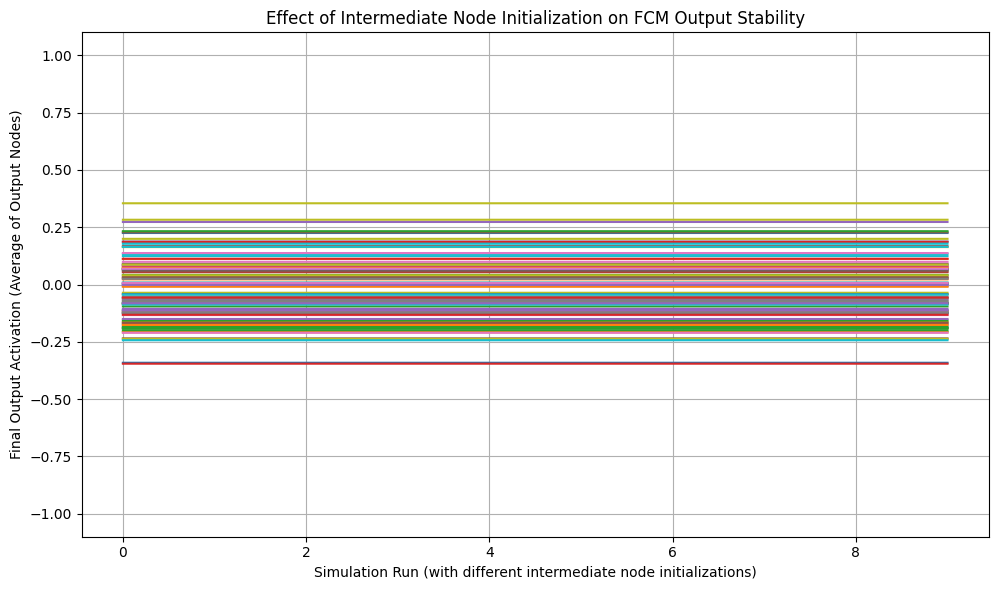

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
import re
import unicodedata

# --- Normalize node names for consistency ---
def clean_node_name(name):
    name = str(name).strip().lower()
    name = unicodedata.normalize("NFKD", name)
    name = re.sub(r'[\u200b-\u200f\u202a-\u202e\u00a0]', '', name)
    return name

# --- Normalize weight to target range (default: [0,1]) ---
def normalize_weight(w, original_min=0, original_max=5, target_min=0, target_max=1):
    if w is None:
        return 0
    w = float(w)
    return ((w - original_min) / (original_max - original_min)) * (target_max - target_min) + target_min

# --- Convert a NetworkX graph into a numerical adjacency matrix ---
def graph_to_fcm(g, weight_property=None, normalize=True):
    num_vertices = len(g.nodes())
    fcm_matrix = np.zeros((num_vertices, num_vertices))
    node_index = {node: idx for idx, node in enumerate(g.nodes())}

    for source, target, data in g.edges(data=True):
        source_idx = node_index[source]
        target_idx = node_index[target]
        if weight_property and weight_property in data:
            weight = data[weight_property]
            if normalize:
                weight = normalize_weight(weight)
            fcm_matrix[source_idx, target_idx] = weight
        else:
            fcm_matrix[source_idx, target_idx] = 1.0
    return fcm_matrix

# --- Triangular membership function for 3 fuzzy levels ---
def triangular_membership(x, a, b, c):
    if x < a or x > c:
        return 0.0
    elif x == b:
        return 1.0
    elif x < b:
        return (x - a) / (b - a) if (b - a) != 0 else 0.0
    else:
        return (c - x) / (c - b) if (c - b) != 0 else 0.0

# --- Fuzzify crisp BSP value to 5-level fuzzy vector ---
def fuzzify_bsp_input(value):
    x = float(value)
    return [
        max(0, 1 - 4 * x),
        max(0, 1 - abs(4 * x - 1)),
        max(0, 1 - abs(4 * x - 2)),
        max(0, 1 - abs(4 * x - 3)),
        max(0, 4 * x - 3) if x >= 0.75 else 0
    ]

# --- Defuzzify fuzzy vector to crisp scalar ---
def defuzzify(fuzzy_vector):
    weights = [-1.0, -0.5, 0.0, 0.5, 1.0]
    return sum(f * w for f, w in zip(fuzzy_vector, weights)) / sum(fuzzy_vector)

# --- Tanh-based nonlinear activation function ---
def nonlinear_transition(weighted_sum, total_weight, alpha=1.5):
    if total_weight == 0:
        return 0.0
    return np.tanh(alpha * (weighted_sum / total_weight))

# --- Initialize full FCM state (one time per scenario) ---
def initialize_fixed_fcm_state(graph, bsp_inputs, random_values,
                               behavior_pattern=r"_behavior_\d+$",
                               random_keyword="random",
                               output_range=(-1, 1),
                               intermediate_range=(-1, 1)):
    init_state = {}
    Random_variables_list = []
    Random_variable_Name = []
    root_nodes = []
    root_nodes_name = []
    Output_list = []
    Output_Variable_Name = []

    for i, (node, data) in enumerate(graph.nodes(data=True)):
        name = clean_node_name(data.get('name', str(node)))
        label = clean_node_name(data.get('label', str(node)))
        is_random = random_keyword in name
        is_behavior = re.search(behavior_pattern, label)
        is_bsp = name in bsp_inputs
        is_root = graph.in_degree(node) == 0

        if is_random:
            Random_variables_list.append(i)
            Random_variable_Name.append(label)
            init_state[i] = random_values.get(i, 0.0)
        elif is_bsp:
            init_state[i] = bsp_inputs[name]
        elif is_behavior:
            Output_list.append(i)
            Output_Variable_Name.append(label)
            raw_val = np.random.uniform(*output_range)
            init_state[i] = {
                'Low': triangular_membership(raw_val, -1.0, -1.0, 0.0),
                'Medium': triangular_membership(raw_val, -1.0, 0.0, 1.0),
                'High': triangular_membership(raw_val, 0.0, 1.0, 1.0)
            }
        else:
            init_state[i] = 0.0  # Placeholder to be randomized per simulation

        if is_root:
            root_nodes.append(i)
            root_nodes_name.append(label)

    return init_state, Random_variables_list, root_nodes, Output_list

# --- FCM propagation loop with numeric output ---
def fcm_simulation_numeric(fcm_matrix, init_state, root_nodes, random_nodes,
                           iterations=10, alpha=1.5):
    num_nodes = fcm_matrix.shape[0]
    current_state = init_state.copy()

    for _ in range(iterations):
        next_state = current_state.copy()
        for i in range(num_nodes):
            if i in root_nodes or i in random_nodes:
                continue
            weighted_sum, total_weight = 0.0, 0.0
            for j in range(num_nodes):
                w = fcm_matrix[j, i]
                if w == 0:
                    continue
                input_val = current_state.get(j, 0.0)
                if isinstance(input_val, dict):
                    input_val = defuzzify(list(input_val.values()))
                elif isinstance(input_val, list):
                    input_val = defuzzify(input_val)
                weighted_sum += input_val * w
                total_weight += abs(w)
            next_state[i] = nonlinear_transition(weighted_sum, total_weight, alpha)
        current_state = next_state
    return current_state

# --- Main execution: run simulation using fixed input and random intermediate nodes ---
def run_simulation_on_graph(all_network):
    fcm_matrix = graph_to_fcm(all_network, weight_property="weight", normalize=True)

    scenarios = 100
    simulations = 10
    root_range = (0.0, 1.0)
    random_range = (-1.0, 1.0)
    intermediate_range = (-1.0, 1.0)

    # Identify BSP input nodes (not random, and in-degree = 0)
    bsp_nodes = [clean_node_name(data.get("name", str(n))) for n, data in all_network.nodes(data=True)
                 if all_network.in_degree(n) == 0 and "random" not in clean_node_name(data.get("name", ""))]

    root_lhs = lhs(len(bsp_nodes), samples=scenarios)
    root_lhs = root_range[0] + (root_range[1] - root_range[0]) * root_lhs

    results = np.zeros((scenarios, simulations))

    for s in range(scenarios):
        # Fix BSP inputs and random variable values once per scenario
        bsp_inputs = {
            bsp_nodes[i]: fuzzify_bsp_input(root_lhs[s][i]) for i in range(len(bsp_nodes))
        }

        random_values = {}
        for i, (node, data) in enumerate(all_network.nodes(data=True)):
            name = clean_node_name(data.get("name", ""))
            if "random" in name:
                random_values[i] = np.random.uniform(*random_range)

        for sim in range(simulations):
            # Initialize state with fixed BSP + random, and randomized intermediate nodes
            init_state, rand_list, root_list, out_list = initialize_fixed_fcm_state(
                all_network, bsp_inputs, random_values,
                intermediate_range=intermediate_range
            )

            # Randomize only intermediate nodes
            for i in all_network.nodes():
                if i not in root_list and i not in rand_list and i not in out_list:
                    init_state[i] = np.random.uniform(*intermediate_range)

            final_state = fcm_simulation_numeric(
                fcm_matrix, init_state, root_list, rand_list, iterations=10
            )

            # Average over all output nodes
            out_vals = []
            for n in out_list:
                val = final_state[n]
                if isinstance(val, dict):
                    out_vals.append(defuzzify(list(val.values())))
                elif isinstance(val, list):
                    out_vals.append(defuzzify(val))
                else:
                    out_vals.append(val)
            results[s, sim] = np.mean(out_vals)

    # --- Plot results for visual inspection of output stability ---
    plt.figure(figsize=(10, 6))
    for i in range(scenarios):
        plt.plot(results[i], label=f"Scenario {i+1}")
    plt.xlabel("Simulation Run (with different intermediate node initializations)")
    plt.ylabel("Final Output Activation (Average of Output Nodes)")
    plt.title("Effect of Intermediate Node Initialization on FCM Output Stability")
    plt.grid(True)
    plt.tight_layout()
    plt.ylim(-1.1, 1.1)
    plt.show()

run_simulation_on_graph(all_network)
